# Customer Churn Prediction with Python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")


## Loading the data set

In [ ]:
# Load the Excel workbook
file_path = "/content/Customer_Churn_Data_Large (1).xlsx"
xls = pd.ExcelFile(file_path)

# Parse each relevant sheet
demographics = xls.parse("Customer_Demographics")
transactions = xls.parse("Transaction_History")
service = xls.parse("Customer_Service")
activity = xls.parse("Online_Activity")
churn = xls.parse("Churn_Status")

# Aggregate Transaction History
transaction_summary = transactions.groupby("CustomerID").agg({
    "AmountSpent": ["sum", "mean", "count"],
    "ProductCategory": pd.Series.nunique
}).reset_index()
transaction_summary.columns = ["CustomerID", "TotalSpent", "AvgSpent", "NumTransactions", "UniqueCategories"]

# Step 4: Aggregate Customer Service Interactions
service_summary = service.groupby("CustomerID").agg({
    "InteractionID": "count",
    "ResolutionStatus": lambda x: (x == "Unresolved").sum()
}).reset_index()
service_summary.columns = ["CustomerID", "NumInteractions", "UnresolvedIssues"]

# Step 5: Process Online Activity
activity["LastLoginDate"] = pd.to_datetime(activity["LastLoginDate"])
latest_date = activity["LastLoginDate"].max()
activity["DaysSinceLastLogin"] = (latest_date - activity["LastLoginDate"]).dt.days
activity_summary = activity[["CustomerID", "LoginFrequency", "ServiceUsage", "DaysSinceLastLogin"]]

# Step 6: Merge all into a master DataFrame
merged_df = demographics \
    .merge(transaction_summary, on="CustomerID", how="left") \
    .merge(service_summary, on="CustomerID", how="left") \
    .merge(activity_summary, on="CustomerID", how="left") \
    .merge(churn, on="CustomerID", how="left")
print(merged_df.head())

   CustomerID  Age Gender MaritalStatus IncomeLevel  TotalSpent   AvgSpent  \
0           1   62      M        Single         Low      416.50  416.50000   
1           2   65      M       Married         Low     1547.42  221.06000   
2           3   18      M        Single         Low     1702.98  283.83000   
3           4   21      M       Widowed         Low      917.29  183.45800   
4           5   21      M      Divorced      Medium     2001.49  250.18625   

   NumTransactions  UniqueCategories  NumInteractions  UnresolvedIssues  \
0                1                 1              1.0               0.0   
1                7                 4              1.0               0.0   
2                6                 4              1.0               0.0   
3                5                 4              2.0               1.0   
4                8                 3              NaN               NaN   

   LoginFrequency ServiceUsage  DaysSinceLastLogin  ChurnStatus  
0             

In [ ]:
merged_df.to_csv("merged_customer_churn_data.csv", index=False)

In [ ]:
merged_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,NumTransactions,UniqueCategories,NumInteractions,UnresolvedIssues,LoginFrequency,ServiceUsage,DaysSinceLastLogin,ChurnStatus
0,1,62,M,Single,Low,416.50,416.50000,1,1,1.0,0.0,34,Mobile App,71,0
1,2,65,M,Married,Low,1547.42,221.06000,7,4,1.0,0.0,5,Website,26,1
2,3,18,M,Single,Low,1702.98,283.83000,6,4,1.0,0.0,3,Website,46,0
3,4,21,M,Widowed,Low,917.29,183.45800,5,4,2.0,1.0,2,Website,128,0
4,5,21,M,Divorced,Medium,2001.49,250.18625,8,3,NaN,NaN,41,Website,65,0


## Understanding the data set

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   Age                 1000 non-null   int64  
 2   Gender              1000 non-null   object 
 3   MaritalStatus       1000 non-null   object 
 4   IncomeLevel         1000 non-null   object 
 5   TotalSpent          1000 non-null   float64
 6   AvgSpent            1000 non-null   float64
 7   NumTransactions     1000 non-null   int64  
 8   UniqueCategories    1000 non-null   int64  
 9   NumInteractions     668 non-null    float64
 10  UnresolvedIssues    668 non-null    float64
 11  LoginFrequency      1000 non-null   int64  
 12  ServiceUsage        1000 non-null   object 
 13  DaysSinceLastLogin  1000 non-null   int64  
 14  ChurnStatus         1000 non-null   int64  
dtypes: float64(4), int64(7), object(4)
memory usage: 117.3+ 

NumInteractions and UnresolvedIssues have 668 non-null float values. This indicates presence of 332 missing values.

 CustomerID, Age, NumTransactions, UniqueCategories, DaysSinceLastLogin and ChurnStatus are intergers.


 Gender, MaritalStatus, IncomeLevel and ServiceUsage are object types.

TotalSpent andvalues AvgSpent are float values

## Data Cleaning

In [ ]:
# Check for missing values
missing_values = merged_df.isnull().sum()

In [ ]:
missing_values

,0
CustomerID,0
Age,0
Gender,0
MaritalStatus,0
IncomeLevel,0
TotalSpent,0
AvgSpent,0
NumTransactions,0
UniqueCategories,0
NumInteractions,332


Missing interaction data indicates no interaction.

In [ ]:
merged_df["NumInteractions"] = merged_df["NumInteractions"].fillna(0)
merged_df["UnresolvedIssues"] = merged_df["UnresolvedIssues"].fillna(0)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   Age                 1000 non-null   int64  
 2   Gender              1000 non-null   object 
 3   MaritalStatus       1000 non-null   object 
 4   IncomeLevel         1000 non-null   object 
 5   TotalSpent          1000 non-null   float64
 6   AvgSpent            1000 non-null   float64
 7   NumTransactions     1000 non-null   int64  
 8   UniqueCategories    1000 non-null   int64  
 9   NumInteractions     1000 non-null   float64
 10  UnresolvedIssues    1000 non-null   float64
 11  LoginFrequency      1000 non-null   int64  
 12  ServiceUsage        1000 non-null   object 
 13  DaysSinceLastLogin  1000 non-null   int64  
 14  ChurnStatus         1000 non-null   int64  
dtypes: float64(4), int64(7), object(4)
memory usage: 117.3+ 

In [ ]:
# Check for duplicate records
duplicates = merged_df.duplicated().sum()

In [ ]:
duplicates

np.int64(0)

The data is now clean. No missing values and duplicates.

In [ ]:
merged_df.describe()

,CustomerID,Age,TotalSpent,AvgSpent,NumTransactions,UniqueCategories,NumInteractions,UnresolvedIssues,LoginFrequency,DaysSinceLastLogin,ChurnStatus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,43.267000,1267.074950,248.806511,5.054000,3.097000,1.002000,0.479000,25.912000,178.105000,0.204000
std,288.819436,15.242311,738.590013,79.372766,2.603433,1.252661,0.816494,0.621245,14.055953,104.897299,0.403171
min,1.000000,18.000000,9.800000,9.800000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,250.750000,30.000000,626.685000,203.734167,3.000000,2.000000,0.000000,0.000000,13.750000,90.750000,0.000000
50%,500.500000,43.000000,1232.880000,250.121458,5.000000,3.000000,1.000000,0.000000,27.000000,173.500000,0.000000
75%,750.250000,56.000000,1791.902500,295.023854,7.000000,4.000000,2.000000,1.000000,38.000000,267.000000,0.000000
max,1000.000000,69.000000,3386.040000,496.990000,9.000000,5.000000,2.000000,2.000000,49.000000,364.000000,1.000000


## Exploratory Data Analysis

Let us understand churn distribution(targer imbalance), examine feature correlations, compare numerical feartures and analyze categorical feartures. we will also detect outliers and handle them to imorove the perfomance of the model.

### Detecting outliers

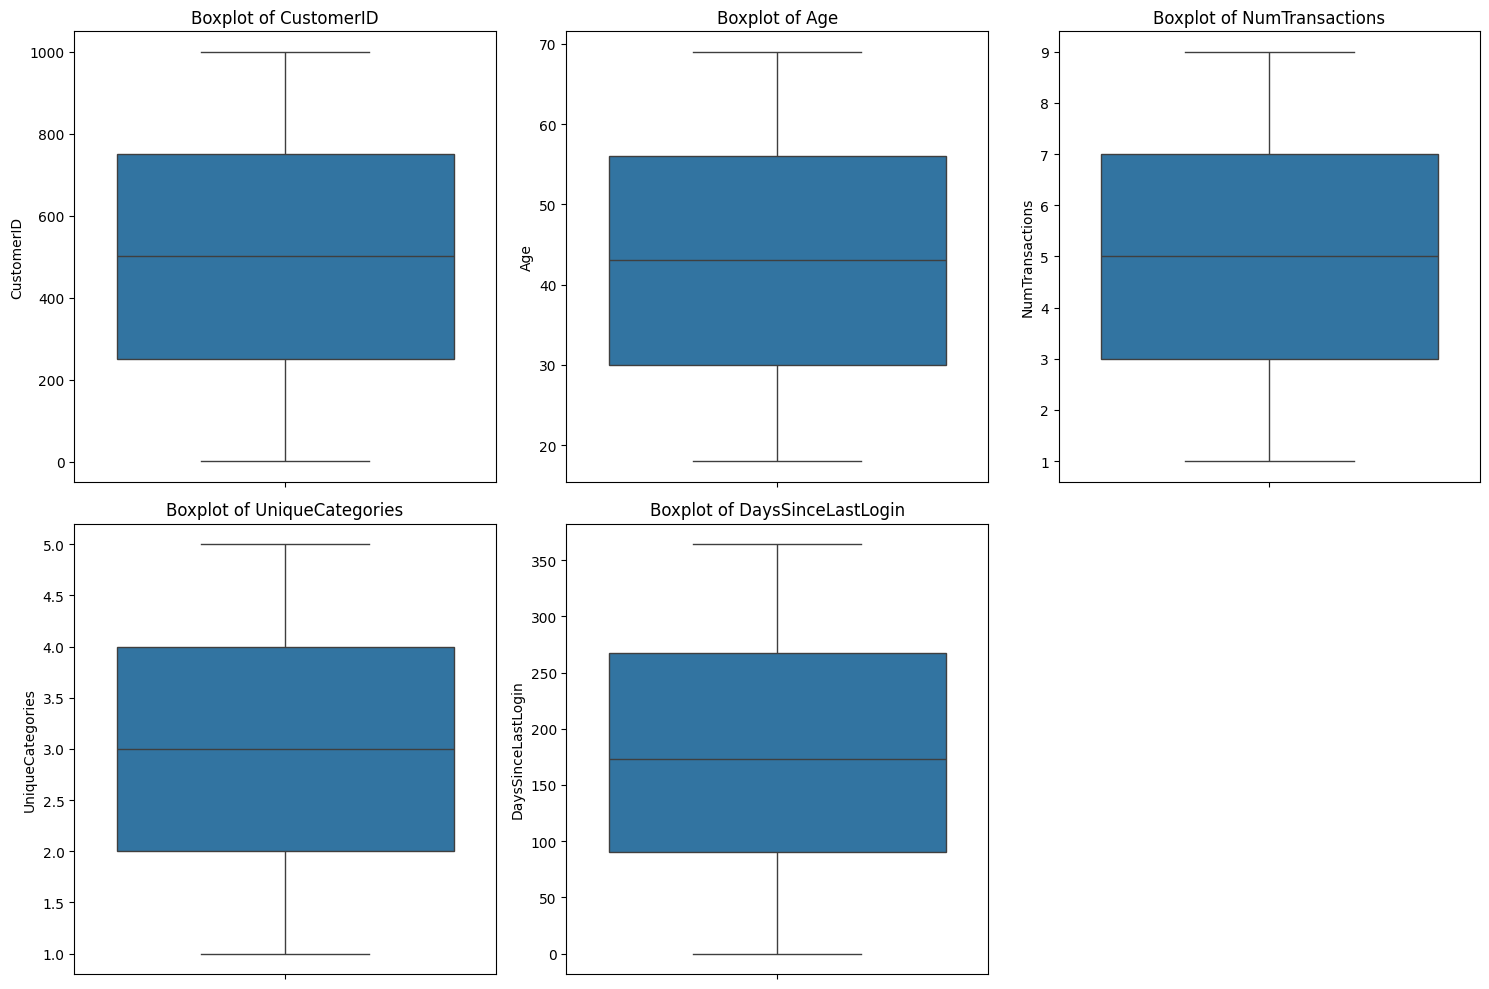

In [ ]:
# Plot boxplots to detect outliers
plt.figure(figsize=(15, 10))
cols_to_plot = ["CustomerID", "Age", "NumTransactions", "UniqueCategories", "DaysSinceLastLogin"]

# Calculate the number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols # Calculate required rows

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=merged_df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

The data has no outliers.

### Understanding churn distribution.

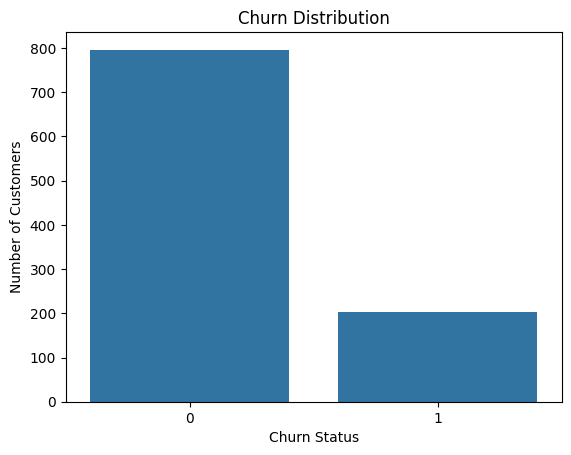

Churn Distribution
(0: Not Churned, 1: Churned)
{0: 79.60000000000001, 1: 20.4}


In [ ]:
churn_counts = merged_df['ChurnStatus'].value_counts(normalize=True) * 100
sns.countplot(x='ChurnStatus', data=merged_df)
plt.title(f"Churn Distribution")
plt.xlabel("Churn Status")
plt.ylabel("Number of Customers")
plt.show()

print(f"Churn Distribution\n(0: Not Churned, 1: Churned)\n{churn_counts.to_dict()}")

This a class imbalance problem.

### Comparison of numerical feartures

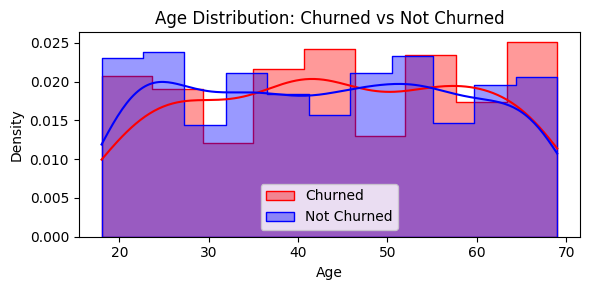

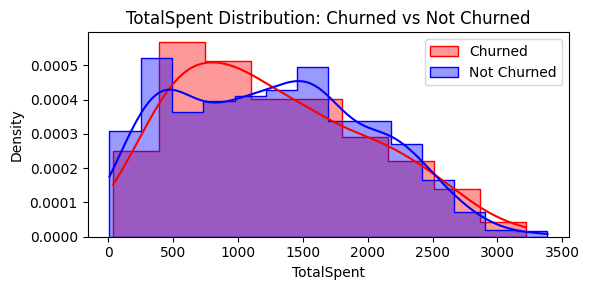

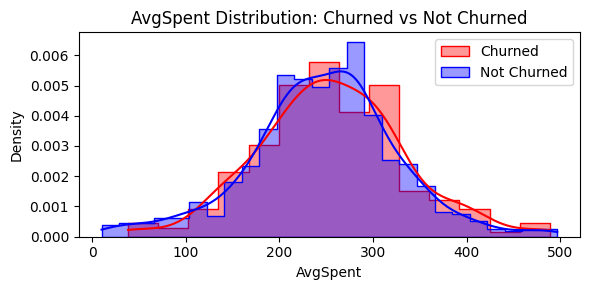

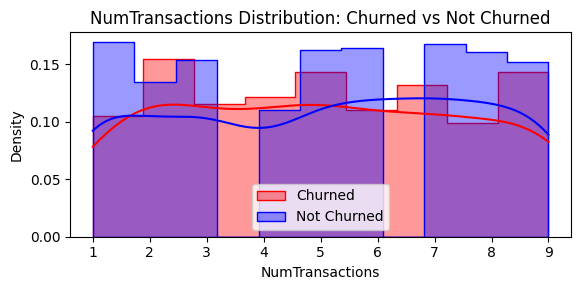

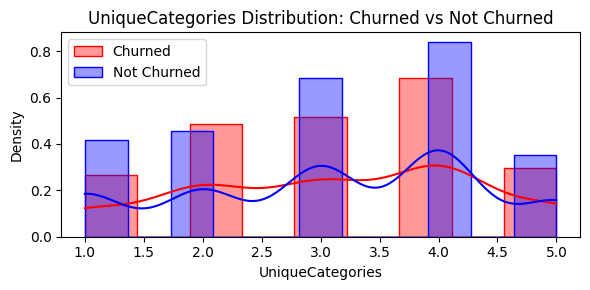

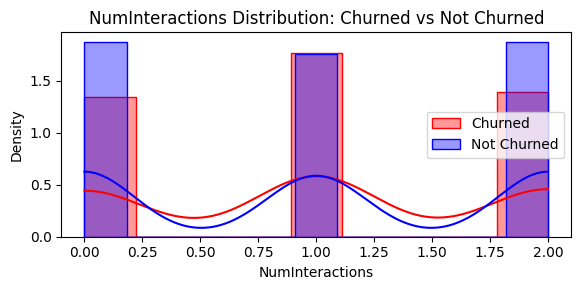

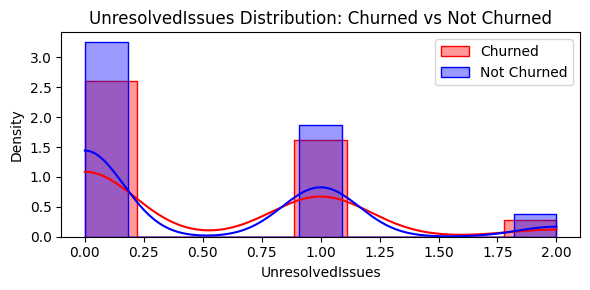

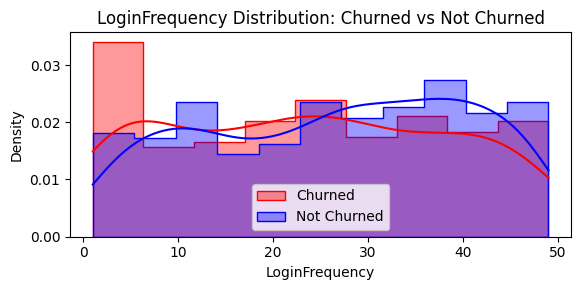

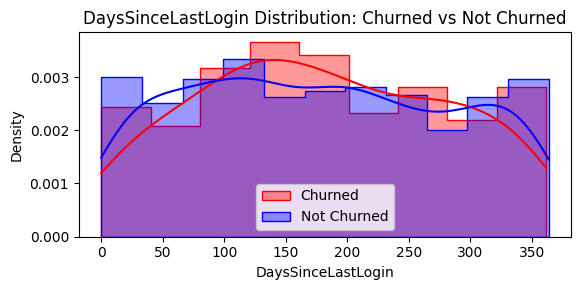

In [ ]:
numeric_cols = ["Age", "TotalSpent", "AvgSpent", "NumTransactions", "UniqueCategories",
                "NumInteractions", "UnresolvedIssues", "LoginFrequency", "DaysSinceLastLogin"]

for col in numeric_cols:
    plt.figure(figsize=(6, 3))

    # Churned
    sns.histplot(merged_df[merged_df['ChurnStatus'] == 1][col],
                 color='red', label='Churned', kde=True, stat='density', element='step', fill=True, alpha=0.4)

    # Not Churned
    sns.histplot(merged_df[merged_df['ChurnStatus'] == 0][col],
                 color='blue', label='Not Churned', kde=True, stat='density', element='step', fill=True, alpha=0.4)

    plt.title(f"{col} Distribution: Churned vs Not Churned")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



### Categorical analysis

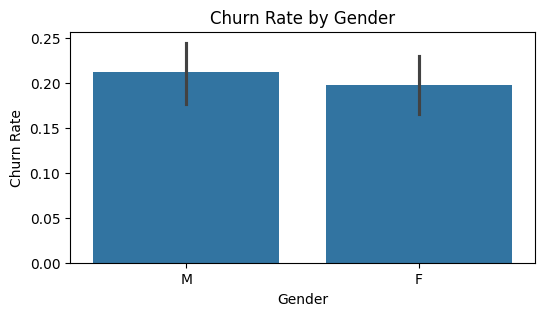

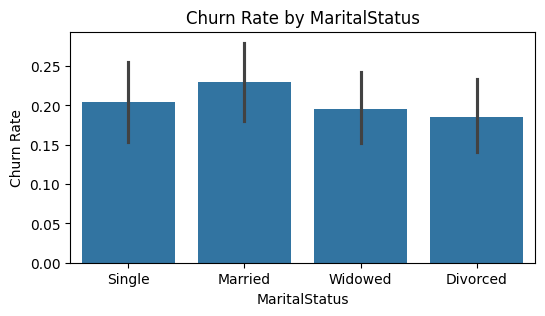

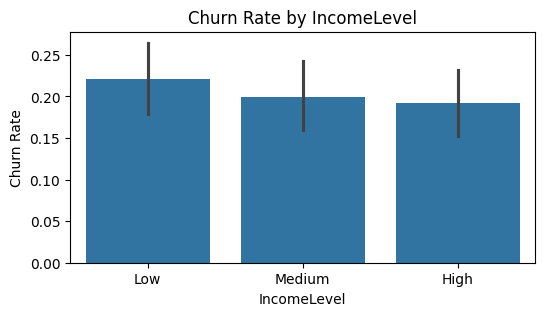

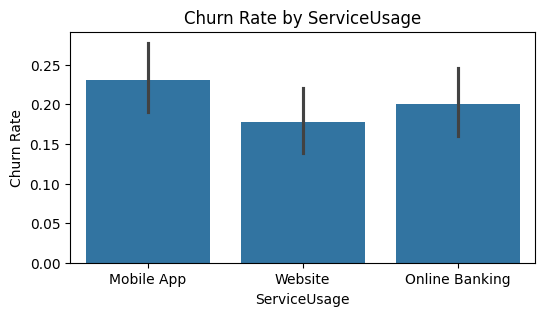

In [ ]:
categorical_cols = ["Gender", "MaritalStatus", "IncomeLevel", "ServiceUsage"]

for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.barplot(x=col, y="ChurnStatus", data=merged_df)
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Rate")
    plt.show()


### Correlation mateix

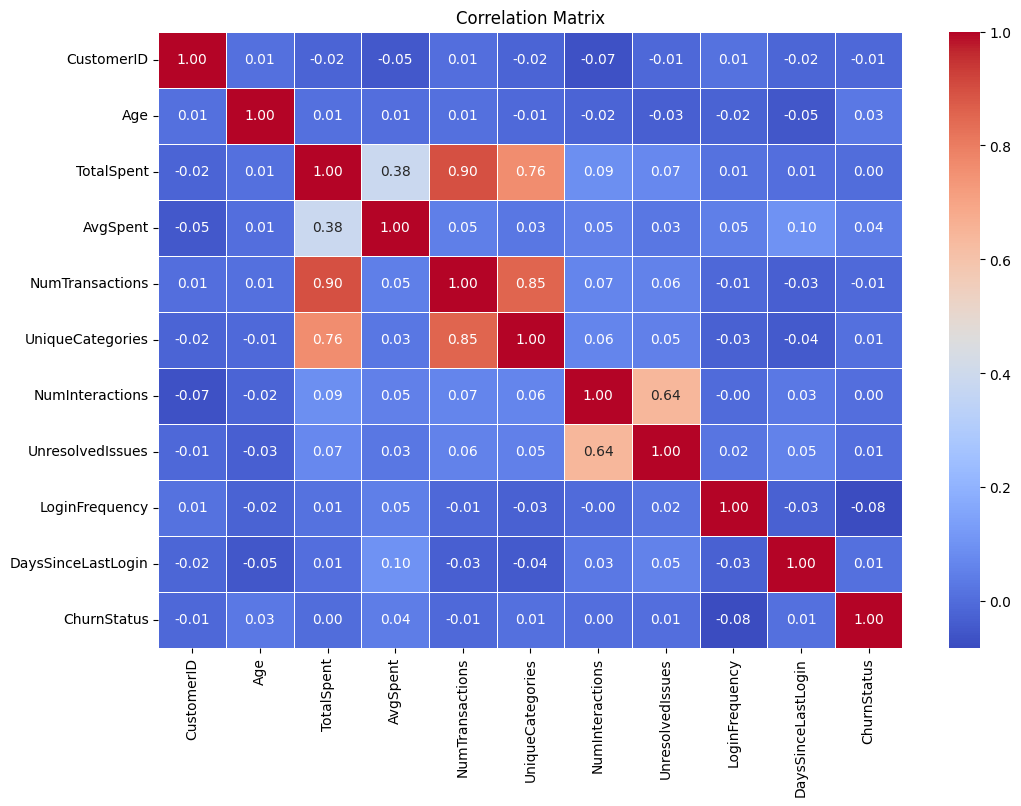

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = merged_df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Feature Engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables using Label Encoding
categorical_cols = ["Gender", "MaritalStatus", "IncomeLevel", "ServiceUsage"]
encoder = LabelEncoder()

for col in categorical_cols:
   merged_df[col] = encoder.fit_transform(merged_df[col])

# Normalize numerical variables
scaler = StandardScaler()
numeric_cols = ["Age", "TotalSpent", "AvgSpent", "NumTransactions", "UniqueCategories",
                "NumInteractions", "UnresolvedIssues", "LoginFrequency", "DaysSinceLastLogin"]
merged_df[numeric_cols] = scaler.fit_transform(merged_df[numeric_cols])

# Display first few rows after feature engineering
merged_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,NumTransactions,UniqueCategories,NumInteractions,UnresolvedIssues,LoginFrequency,ServiceUsage,DaysSinceLastLogin,ChurnStatus
0,1,1.229628,1,2,1,-1.152196,2.113790,-1.557954,-1.674874,-0.002451,-0.771419,0.575702,0,-1.021557,0
1,2,1.426547,1,1,1,0.379758,-0.349747,0.747849,0.721226,-0.002451,-0.771419,-1.488513,2,-1.450763,1
2,3,-1.658518,1,2,1,0.590481,0.441474,0.363548,0.721226,-0.002451,-0.771419,-1.630872,2,-1.260005,0
3,4,-1.461599,1,3,1,-0.473822,-0.823723,-0.020752,0.721226,1.222911,0.839059,-1.702052,2,-0.477897,0
4,5,-1.461599,1,0,2,0.994845,0.017392,1.132149,-0.077474,-1.227812,-0.771419,1.073961,2,-1.078785,0


### Adding features

In [ ]:
# Derived Ratio Features
merged_df['SpendPerTransaction'] = merged_df['TotalSpent'] / merged_df['NumTransactions'].replace(0, np.nan)
merged_df['SpendPerLogin'] = merged_df['TotalSpent'] / merged_df['LoginFrequency'].replace(0, np.nan)
merged_df['IssuesPerInteraction'] = merged_df['UnresolvedIssues'] / merged_df['NumInteractions'].replace(0, np.nan)
merged_df['TransactionRate'] = merged_df['NumTransactions'] / merged_df['DaysSinceLastLogin'].replace(0, np.nan)
merged_df['InteractionRate'] = merged_df['NumInteractions'] / merged_df['DaysSinceLastLogin'].replace(0, np.nan)
merged_df['CategoryDiversityRatio'] = merged_df['UniqueCategories'] / merged_df['NumTransactions'].replace(0, np.nan)

# Engagement and Status Flags
merged_df['IsDormant'] = (merged_df['DaysSinceLastLogin'] > 30).astype(int)
merged_df['HighSupportUsage'] = (merged_df['NumInteractions'] > merged_df['NumInteractions'].quantile(0.75)).astype(int)
merged_df['HighUnresolved'] = (merged_df['UnresolvedIssues'] > merged_df['UnresolvedIssues'].quantile(0.75)).astype(int)

# Combined Interaction Features
merged_df['Spent_vs_Issues'] = merged_df['TotalSpent'] / (1 + merged_df['UnresolvedIssues'].fillna(0))
merged_df['LoginSpendRatio'] = merged_df['LoginFrequency'] / (1 + merged_df['TotalSpent'])
merged_df['IssueAdjustedLoyalty'] = merged_df['NumTransactions'] / (1 + merged_df['UnresolvedIssues'].fillna(0))

# Demographic Flags
merged_df['IsSenior'] = (merged_df['Age'] >= 60).astype(int)
merged_df['IsYoungAdult'] = ((merged_df['Age'] >= 18) & (merged_df['Age'] <= 30)).astype(int)
merged_df['IsLowIncome'] = merged_df['IncomeLevel'].isin(['Low', 'Very Low']).astype(int)

# --- Clean Infinite and Missing ---
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.fillna(0, inplace=True)


In [ ]:
merged_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,NumTransactions,UniqueCategories,NumInteractions,...,CategoryDiversityRatio,IsDormant,HighSupportUsage,HighUnresolved,Spent_vs_Issues,LoginSpendRatio,IssueAdjustedLoyalty,IsSenior,IsYoungAdult,IsLowIncome
0,1,1.229628,1,2,1,-1.152196,2.113790,-1.557954,-1.674874,-0.002451,...,1.075047,0,0,0,-5.040638,-3.782635,-6.815751,0,0,0
1,2,1.426547,1,1,1,0.379758,-0.349747,0.747849,0.721226,-0.002451,...,0.964401,0,0,0,1.661368,-1.078822,3.271695,0,0,0
2,3,-1.658518,1,2,1,0.590481,0.441474,0.363548,0.721226,-0.002451,...,1.983852,0,0,0,2.583240,-1.025396,1.590454,0,0,0
3,4,-1.461599,1,3,1,-0.473822,-0.823723,-0.020752,0.721226,1.222911,...,-34.754153,0,0,0,-0.257644,-3.234744,-0.011284,0,0,0
4,5,-1.461599,1,0,2,0.994845,0.017392,1.132149,-0.077474,-1.227812,...,-0.068431,0,0,0,4.352256,0.538368,4.952936,0,0,0


## Churn Prediction Model

In [54]:
# Define features and target variable
X = merged_df.drop(columns=["ChurnStatus"])
y = merged_df["ChurnStatus"]

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
import joblib

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [57]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [59]:
# Train and evaluate models
results = {}
best_model = None
best_model_name = None
best_accuracy = 0
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    # Save the best model based on highest accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

    results[name] = {
        "Accuracy": accuracy,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)
results_df

,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.795,0.632025,0.795,0.704206
SVM,0.795,0.632025,0.795,0.704206
Random Forest,0.790,0.631206,0.790,0.701732
Gradient Boosting,0.760,0.651286,0.760,0.694171
XGBoost,0.755,0.686386,0.755,0.710201
KNN,0.750,0.645382,0.750,0.688660
Decision Tree,0.655,0.675570,0.655,0.664685


The best perfomed model is Logistic regression and SVM with an accuracy of 79.5

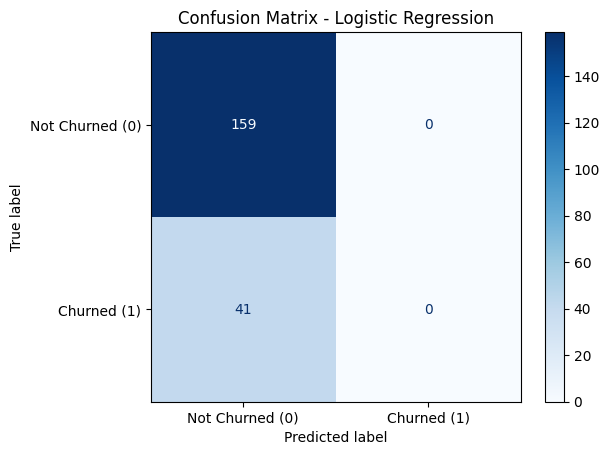

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Not Churned (0)', 'Churned (1)'])
disp.plot(cmap='Blues', values_format='d')

plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

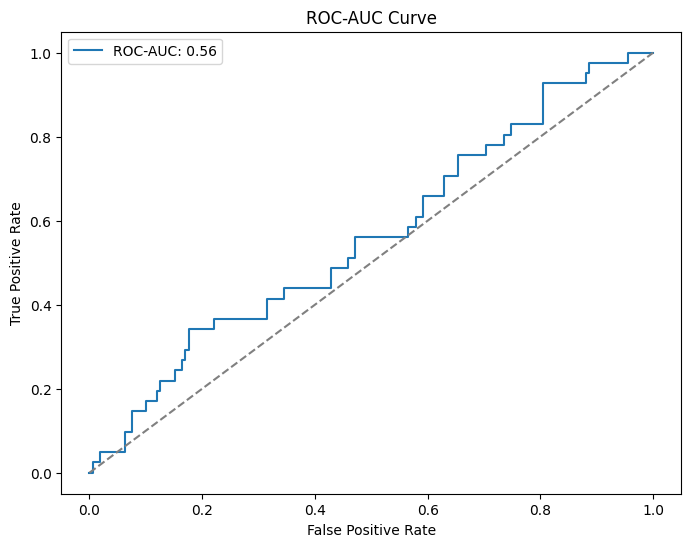

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# ROC-AUC Curve
# Get the predicted probabilities for the positive class (class 1)
# best_model.predict_proba(X_test) returns probabilities for all classes.
# We need the probabilities for the positive class (index 1).
y_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

The project was succefully developed and evaluated by different machine learning models. The best perfomed model was Logistic Regression with the highest accuracy. XGBoost provided the best balance of perfomance with the highest F1 score.